In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [7]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


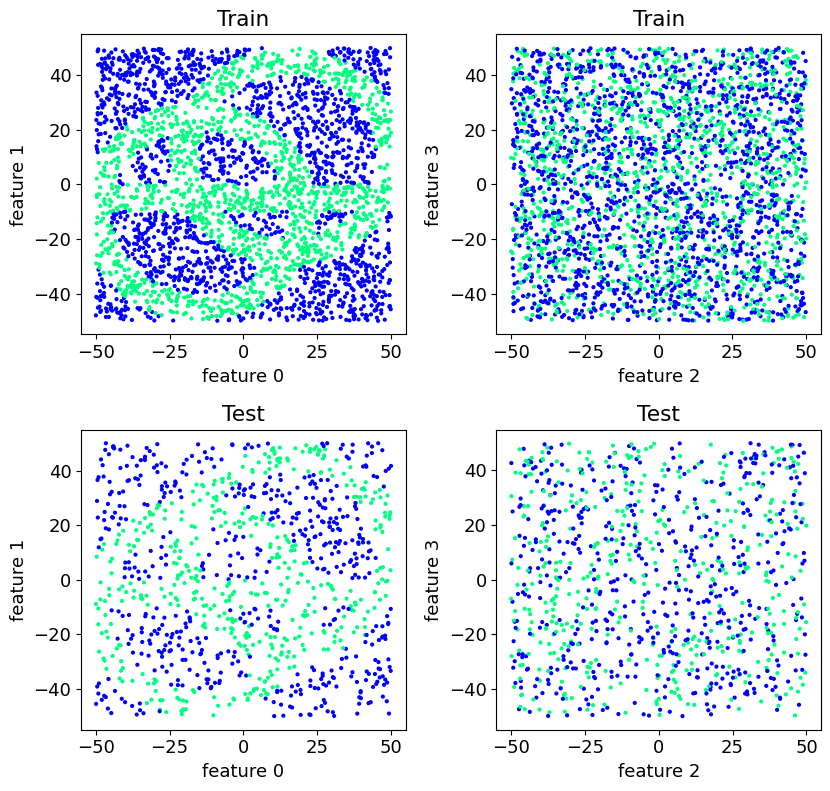

In [8]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [9]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 5.20%   Accuracy=0.948


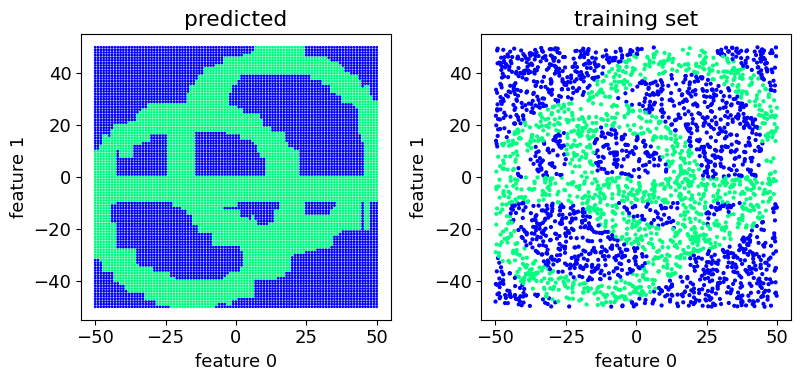

num_trees= 100


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

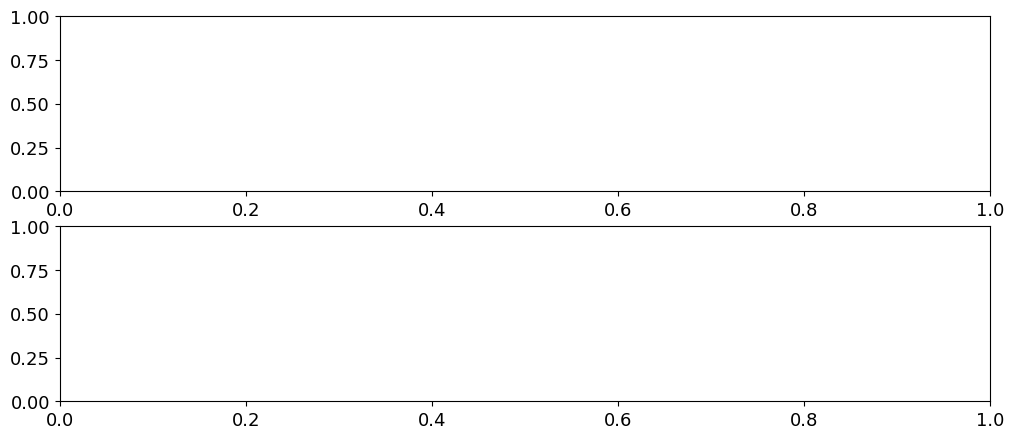

In [10]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(model, show=True)

In [ ]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


In [ ]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## normal Gradient Boosting

In [ ]:
# GradientBoostingClassifier()
classify()

## AdaBoost

In [ ]:
classify(clf=AdaBoostClassifier())